<a href="https://colab.research.google.com/github/LuisFernandoCampos/modelo_peliculas_rentables/blob/main/modelo_peliculas_rentables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [346]:
movie=pd.read_excel("/content/MOVIE.xlsx")
movie.head(2)

,title,main_genre,belongs_to_collection,budget,revenue,production_companies,vote_average,popularity,runtime,cast_size,crew_size,cast_tr_rev,director_tr_rev,production_company_tr_roi,English,title_length,rel_month,rel_year
0,Return of the Living Dead Part II,Comedy,True,6.2,9205924.0,1.0,5.8,6606325.0,89.0,17,2,6.244235e+16,0.0,1.000000e+00,True,27,January,1988
1,The Serpent and the Rainbow,Horror,False,7.0,19595031.0,1.0,6.2,7791952.0,98.0,19,22,4.391367e+16,59493244.0,6.446969e+15,True,23,February,1988


In [347]:
# Creamos la variable objetivo <profitable>
movie["profitable"] = np.where(movie.revenue > movie.budget, 1, 0)

In [348]:
movie["profitable"].value_counts()/len(movie)*100

1    90.019057
0     9.980943
Name: profitable, dtype: float64

# 1. ANÁLISIS EXPLORATORIO DE DATOS

In [349]:
movie.shape

(4198, 19)

In [350]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title                      4198 non-null   object 
 1   main_genre                 4193 non-null   object 
 2   belongs_to_collection      4198 non-null   bool   
 3   budget                     4198 non-null   float64
 4   revenue                    4198 non-null   float64
 5   production_companies       4100 non-null   float64
 6   vote_average               4197 non-null   float64
 7   popularity                 4198 non-null   float64
 8   runtime                    4189 non-null   float64
 9   cast_size                  4198 non-null   int64  
 10  crew_size                  4198 non-null   int64  
 11  cast_tr_rev                4191 non-null   float64
 12  director_tr_rev            4195 non-null   float64
 13  production_company_tr_roi  4198 non-null   float

In [351]:
movie.isna().sum()

title                         0
main_genre                    5
belongs_to_collection         0
budget                        0
revenue                       0
production_companies         98
vote_average                  1
popularity                    0
runtime                       9
cast_size                     0
crew_size                     0
cast_tr_rev                   7
director_tr_rev               3
production_company_tr_roi     0
English                       0
title_length                  0
rel_month                     0
rel_year                      0
profitable                    0
dtype: int64

In [352]:
# Calculamos el CV de las variables numericas
coeficiente_variabilidad= (movie.std() / movie.mean())*100
coeficiente_variabilidad.sort_values(ascending=False)

<ipython-input-352-8dcb491d0527>:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  coeficiente_variabilidad= (movie.std() / movie.mean())*100
<ipython-input-352-8dcb491d0527>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  coeficiente_variabilidad= (movie.std() / movie.mean())*100


budget                       3046.076780
revenue                       433.859481
popularity                    391.978471
director_tr_rev               203.080802
belongs_to_collection         182.812957
cast_tr_rev                   180.782132
production_company_tr_roi     129.834263
crew_size                     108.659514
cast_size                      83.468906
production_companies           68.075165
title_length                   51.822657
English                        35.935001
profitable                     33.301999
runtime                        18.334730
vote_average                   13.962775
rel_year                        0.385255
dtype: float64

In [353]:
movie.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4198.0,3.789033e+13,1.154168e+15,1.070000,1.050000e+01,2.500000e+01,5.300000e+01,5.641880e+16
revenue,4198.0,1.469842e+15,6.377051e+15,0.000006,3.469075e+06,3.295463e+07,1.555250e+08,7.659918e+16
production_companies,4100.0,3.326829e+00,2.264745e+00,1.000000,2.000000e+00,3.000000e+00,4.000000e+00,2.600000e+01
vote_average,4197.0,6.206648e+00,8.666202e-01,1.000000,5.700000e+00,6.200000e+00,6.800000e+00,9.100000e+00
popularity,4198.0,2.943852e+15,1.153927e+16,0.011574,5.346777e+06,9.434856e+06,1.396176e+07,7.979302e+16
runtime,4189.0,1.101062e+02,2.018768e+01,63.000000,9.600000e+01,1.060000e+02,1.200000e+02,3.380000e+02
cast_size,4198.0,2.466556e+01,2.058807e+01,0.000000,1.300000e+01,1.800000e+01,2.900000e+01,2.240000e+02
crew_size,4198.0,3.306336e+01,3.592649e+01,0.000000,1.000000e+01,1.900000e+01,4.300000e+01,4.350000e+02
cast_tr_rev,4191.0,6.912605e+15,1.249675e+16,0.000000,3.433138e+08,2.568927e+09,8.895465e+15,7.774677e+16
director_tr_rev,4195.0,5.186494e+15,1.053277e+16,0.000000,0.000000e+00,1.024808e+08,5.983332e+15,7.993039e+16


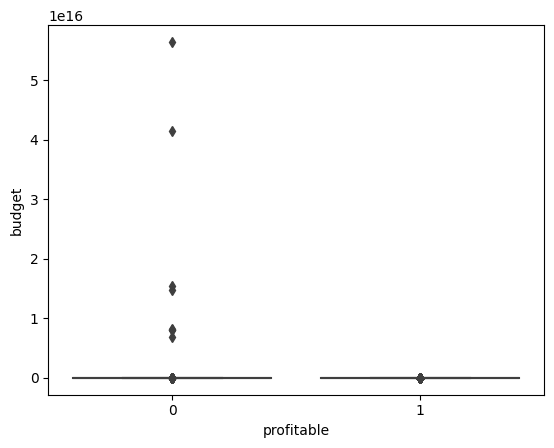

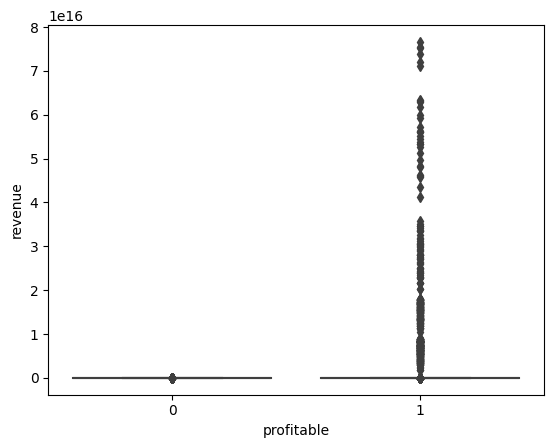

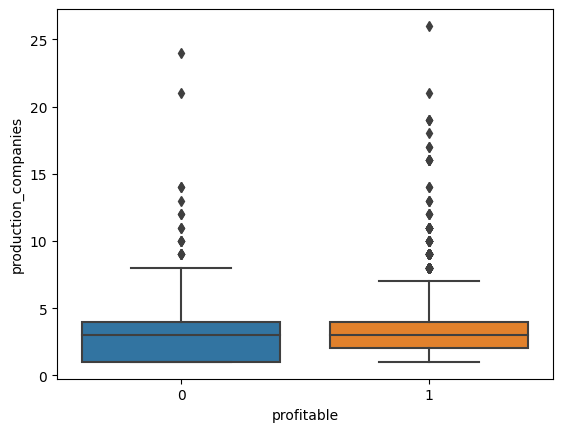

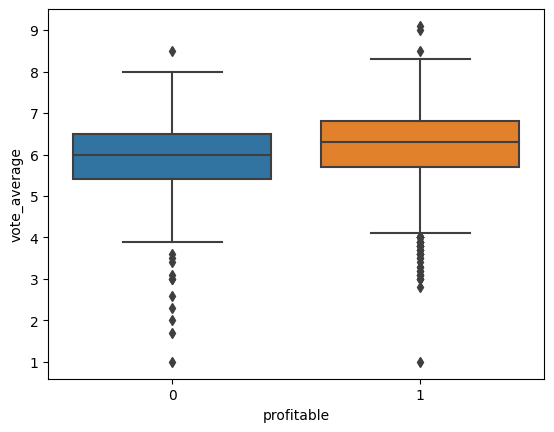

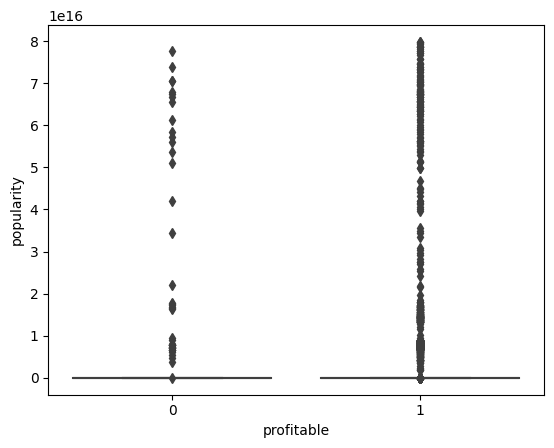

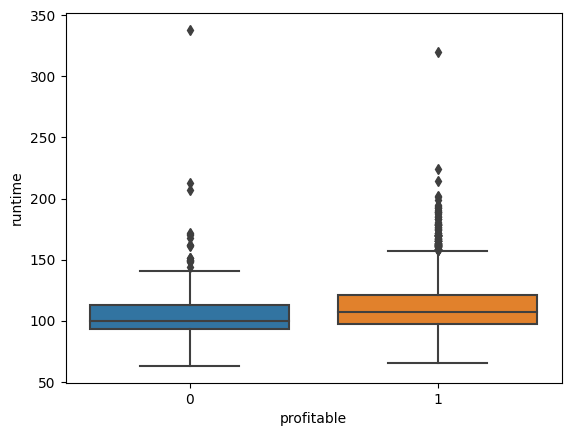

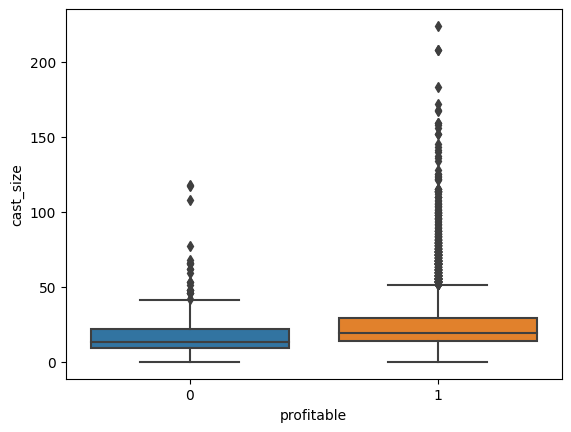

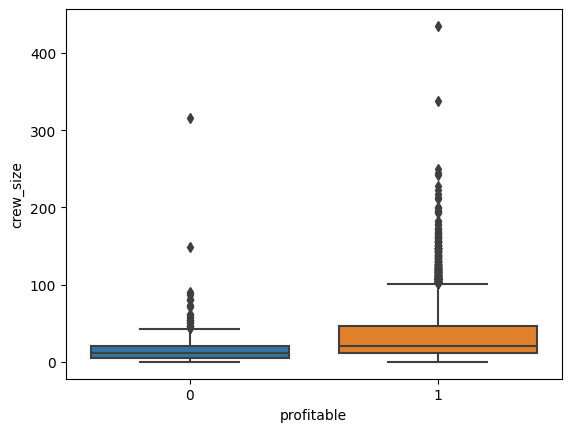

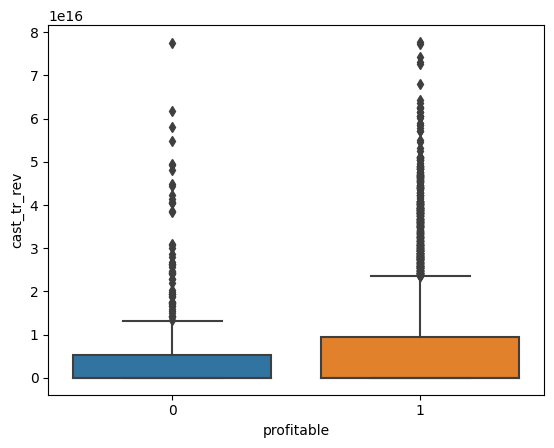

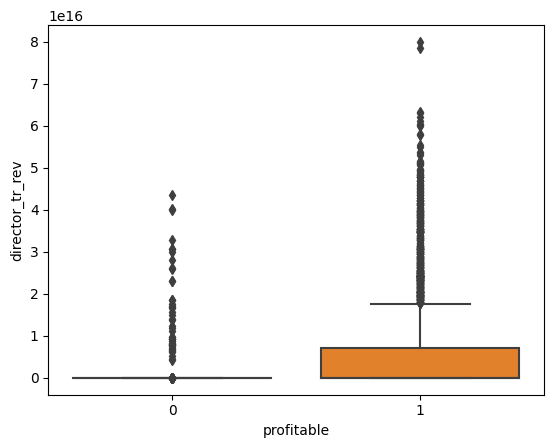

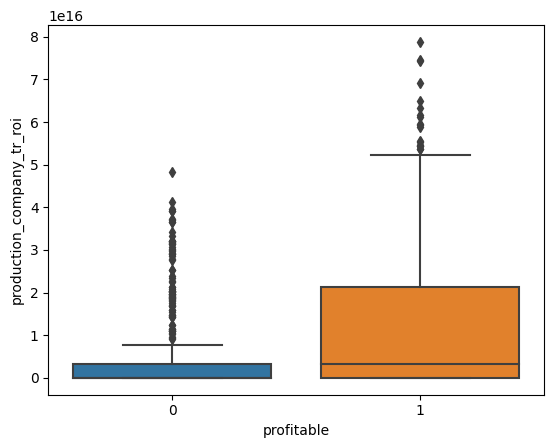

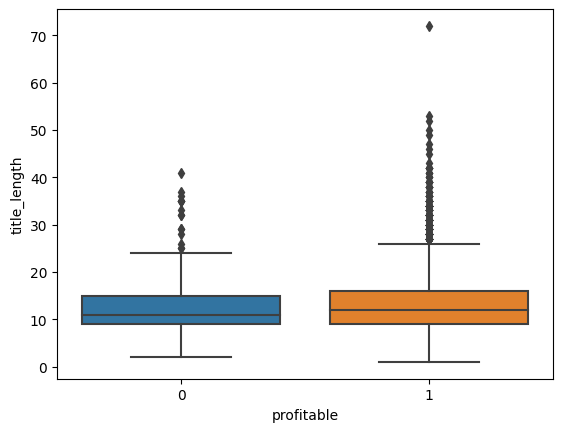

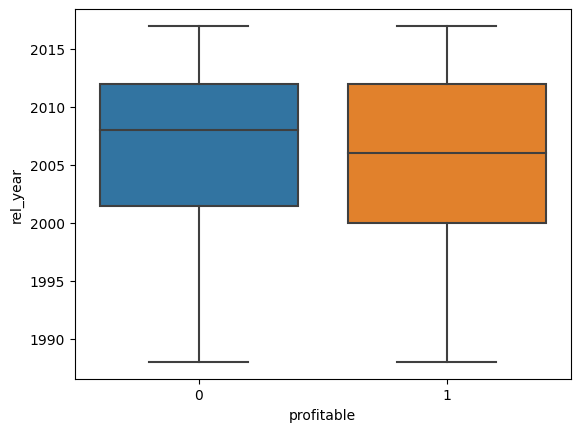

In [354]:
num_col = movie.select_dtypes(include="number").columns.drop("profitable")
for col in num_col:
  sns.boxplot(x=movie["profitable"], y=movie[col])
  plt.show()

# 2. PREPROCESAMIENTO

In [355]:
cat_col=movie.select_dtypes(exclude = "number").columns
cat_col

Index(['title', 'main_genre', 'belongs_to_collection', 'English', 'rel_month'], dtype='object')

In [356]:
movie[cat_col].nunique()

title                    4167
main_genre                 17
belongs_to_collection       2
English                     2
rel_month                  12
dtype: int64

In [357]:
movie.columns

Index(['title', 'main_genre', 'belongs_to_collection', 'budget', 'revenue',
       'production_companies', 'vote_average', 'popularity', 'runtime',
       'cast_size', 'crew_size', 'cast_tr_rev', 'director_tr_rev',
       'production_company_tr_roi', 'English', 'title_length', 'rel_month',
       'rel_year', 'profitable'],
      dtype='object')

In [358]:
# Eliminamos "title" y "revenue"
columnas=['main_genre', 'belongs_to_collection', 'budget',
       'production_companies', 'vote_average', 'popularity', 'runtime',
       'cast_size', 'crew_size', 'cast_tr_rev', 'director_tr_rev',
       'production_company_tr_roi', 'English', 'title_length', 'rel_month',
       'rel_year', 'profitable']

In [359]:
# Modificamos nuestro dataframe con las columnas eliminadas
movie=movie[columnas]

In [360]:
movie.head(3)

,main_genre,belongs_to_collection,budget,production_companies,vote_average,popularity,runtime,cast_size,crew_size,cast_tr_rev,director_tr_rev,production_company_tr_roi,English,title_length,rel_month,rel_year,profitable
0,Comedy,True,6.2,1.0,5.8,6.606325e+06,89.0,17,2,6.244235e+16,0.0,1.000000e+00,True,27,January,1988,1
1,Horror,False,7.0,1.0,6.2,7.791952e+06,98.0,19,22,4.391367e+16,59493244.0,6.446969e+15,True,23,February,1988,1
2,Comedy,False,17.0,1.0,7.0,6.815147e+16,171.0,20,15,2.451545e+16,68546533.0,1.000000e+00,True,29,February,1988,1


In [361]:
# Convertir las variables booleanas a numericas
movie["belongs_to_collection"]=movie["belongs_to_collection"].astype(int)
movie["English"]=movie["English"].astype(int)

<ipython-input-361-7b606afc3c98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie["belongs_to_collection"]=movie["belongs_to_collection"].astype(int)
<ipython-input-361-7b606afc3c98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie["English"]=movie["English"].astype(int)


In [362]:
# Convertir las variables categoricas a numericas
le = LabelEncoder()

movie["main_genre"] = le.fit_transform(movie["main_genre"])
movie["rel_month"] = le.fit_transform(movie["rel_month"])

movie.head()

<ipython-input-362-8381cd87fd53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie["main_genre"] = le.fit_transform(movie["main_genre"])
<ipython-input-362-8381cd87fd53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie["rel_month"] = le.fit_transform(movie["rel_month"])


,main_genre,belongs_to_collection,budget,production_companies,vote_average,popularity,runtime,cast_size,crew_size,cast_tr_rev,director_tr_rev,production_company_tr_roi,English,title_length,rel_month,rel_year,profitable
0,3,1,6.2,1.0,5.8,6.606325e+06,89.0,17,2,6.244235e+16,0.0,1.000000e+00,1,27,4,1988,1
1,9,0,7.0,1.0,6.2,7.791952e+06,98.0,19,22,4.391367e+16,59493244.0,6.446969e+15,1,23,3,1988,1
2,3,0,17.0,1.0,7.0,6.815147e+16,171.0,20,15,2.451545e+16,68546533.0,1.000000e+00,1,29,3,1988,1
3,0,0,7.0,2.0,4.9,1.405486e+07,96.0,19,7,3.507934e+08,0.0,8.013808e+15,1,13,3,1988,1
4,4,0,20.0,2.0,6.6,8.105859e+15,120.0,13,17,2.742150e+09,65037251.0,1.000000e+00,1,7,3,1988,1


In [363]:
movie.to_excel("movie.xlsx", index=False)

In [364]:
df=pd.read_excel("/content/movie.xlsx")
df.head(3)

,main_genre,belongs_to_collection,budget,production_companies,vote_average,popularity,runtime,cast_size,crew_size,cast_tr_rev,director_tr_rev,production_company_tr_roi,English,title_length,rel_month,rel_year,profitable
0,3,1,6.2,1.0,5.8,6.606325e+06,89.0,17,2,6.244235e+16,0.0,1.000000e+00,1,27,4,1988,1
1,9,0,7.0,1.0,6.2,7.791952e+06,98.0,19,22,4.391367e+16,59493244.0,6.446969e+15,1,23,3,1988,1
2,3,0,17.0,1.0,7.0,6.815147e+16,171.0,20,15,2.451545e+16,68546533.0,1.000000e+00,1,29,3,1988,1


In [365]:
df.isna().sum()

main_genre                    0
belongs_to_collection         0
budget                        0
production_companies         98
vote_average                  1
popularity                    0
runtime                       9
cast_size                     0
crew_size                     0
cast_tr_rev                   7
director_tr_rev               3
production_company_tr_roi     0
English                       0
title_length                  0
rel_month                     0
rel_year                      0
profitable                    0
dtype: int64

In [366]:
print("media",df["production_companies"].mean())
print("mediana",df["production_companies"].median())

media 3.3268292682926828
mediana 3.0


In [367]:
# Remplazamos los valores faltantes de la columna "production_companies" por su media
df["production_companies"]=df["production_companies"].fillna(df["production_companies"].mean())

In [368]:
# Eliminamos las filas de las columnas que contienen vacios
df = df.dropna(subset=["vote_average","runtime","cast_tr_rev","director_tr_rev"])

In [369]:
df.isna().sum()

main_genre                   0
belongs_to_collection        0
budget                       0
production_companies         0
vote_average                 0
popularity                   0
runtime                      0
cast_size                    0
crew_size                    0
cast_tr_rev                  0
director_tr_rev              0
production_company_tr_roi    0
English                      0
title_length                 0
rel_month                    0
rel_year                     0
profitable                   0
dtype: int64

# 3. DIVISION DE DATOS

In [370]:
X = df.drop("profitable", axis=1)
y = df["profitable"]

# Nuestros datos estan desequilibrados, aplicamos la tecnica de muestreo "oversampling"
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

1    3769
0    3769
Name: profitable, dtype: int64

In [371]:
# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# 4. PREPARAR, ENTRENAR Y EVALUAR EL MODELO

In [372]:
# Inicializamos el clasificador XGBoost
xgbc = XGBClassifier(random_state=42)

# Entrena el modelo en el conjunto de entrenamiento
xgbc.fit(X_train, y_train)

print("accuracy on training set: ", xgbc.score(X_train, y_train))
print("accuracy on test set: ", xgbc.score(X_test, y_test))

accuracy on training set:  1.0
accuracy on test set:  0.9701591511936339


In [373]:
confusion_matrix(y_test, xgbc.predict(X_test))

array([[742,   0],
       [ 45, 721]])

In [374]:
print("Accuracy: ", metrics.accuracy_score(y_test, xgbc.predict(X_test)))
print("Sensitivity_recall: ", metrics.recall_score(y_test, xgbc.predict(X_test)))
print("Precision: ", metrics.precision_score(y_test, xgbc.predict(X_test)))
print("F1_score: ", metrics.f1_score(y_test, xgbc.predict(X_test)))

Accuracy:  0.9701591511936339
Sensitivity_recall:  0.9412532637075718
Precision:  1.0
F1_score:  0.9697377269670476
